In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode()

In [ ]:
ts = pd.read_csv('../data/sales_weekly.csv', index_col='ds')
ts['ds'] = ts.index
ts['ds'] = pd.to_datetime(ts['ds'])
ts = ts.set_index('ds')

# 3 More Theories and Models

Exponential smoothing and ARIMA models are the two most widely used approaches to time series forecasting, and provide complementary approaches to the problem. While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data.

## 3.1 Exponential Smoothing (ETS)

The simplest of the exponentially smoothing methods is naturally called simple exponential smoothing (SES). This method is suitable for forecasting data with no clear trend or seasonal pattern.

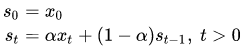


### Holt Winter’s Exponential Smoothing

The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations:
- one for the level; one for the trend; and one for the seasonal component with corresponding smoothing parameters. 

There are two variations to this method that differ in the nature of the seasonal component:
- The additive method is preferred when the seasonal variations are roughly constant through the series, while the multiplicative method is preferred when the seasonal variations are changing proportional to the level of the series.

In [ ]:
train_ts = ts['10_10'][0:-39]
validate_ts = ts['10_10'][-39:]

In [ ]:
hw = sm.tsa.ExponentialSmoothing(train_ts.values, seasonal="add", seasonal_periods=52)

In [ ]:
result = hw.fit().forecast(39)

In [ ]:
layout = go.Layout(autosize=False, width=1000, height=300)
data = [go.Scatter(y=result, name='forecast_holt_winter'),
       go.Scatter(y=validate_ts, name='real')]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [ ]:
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return (np.absolute((predictions - actuals) / actuals)).mean()

In [ ]:
mape(result,validate_ts)

## 3.2 ARIMA (Autoregressive Integrated Moving Average models)

In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable. The term autoregression indicates that it is a regression of the variable against itself.

- We normally restrict autoregressive models to stationary data, Autoregressive models are remarkably flexible at handling a wide range of different time series patterns.

When fitting an ARIMA model to a set of (non-seasonal) time series data, the following procedure provides a useful general approach.

- Plot the data and identify any unusual observations.
- If necessary, transform the data (using a Box-Cox transformation) to stabilise the variance.
- If the data are non-stationary, take first differences of the data until the data are stationary.


### Stationarity

A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

- Time series are stationary if they do not have trend or seasonal effects. The intuition here is that summary statistics (e.g., the mean or the variance of the observations) of the time series are consistent over time.

- When a time series is stationary, it can be easier to model (tightly coupled with the ARMA model). Easier to model does not mean easier to forecast.

- This shows one way to make a non-stationary time series stationary — compute the differences between consecutive observations. This is known as differencing.

- Transformations such as logarithms can help to stabilise the variance of a time series. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

In [ ]:
rand_ts = np.random.normal(loc=0, scale=1, size=1000)

kpss_stat, p_value, lags, crit = sm.tsa.stattools.kpss(rand_ts)
print("kpss: " + str(kpss_stat) + "; p_value: " + str(p_value) +"; lags: " + str(lags) +"; crit: " + str(crit))

kpss_stat, p_value, lags, crit = sm.tsa.stattools.kpss(ts['10_10'].values)
print("kpss: " + str(kpss_stat) + "; p_value: " + str(p_value) +"; lags: " + str(lags) +"; crit: " + str(crit))

kpss_stat, p_value, lags, crit = sm.tsa.stattools.kpss(ts['10_10'].diff()[1:])
print("kpss: " + str(kpss_stat) + "; p_value: " + str(p_value) +"; lags: " + str(lags) +"; crit: " + str(crit))

kpss_stat, p_value, lags, crit = sm.tsa.stattools.kpss(ts['10_10'].diff()[1:].diff()[1:])
print("kpss: " + str(kpss_stat) + "; p_value: " + str(p_value) +"; lags: " + str(lags) +"; crit: " + str(crit))

### Autocorrelation

- Just as correlation measures the extent of a linear relationship between two variables, autocorrelation measures the linear relationship between lagged values of a time series.

- The autocorrelation coefficients are plotted to show the autocorrelation function or ACF. 

- Trend and seasonality in ACF plots: When data have a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase. When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags. When data are both trended and seasonal, you see a combination of these effects. 

- As well as looking at the time plot of the data, the ACF plot is also useful for identifying non-stationary time series. For a stationary time series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly. Also, for non-stationary data, the value is often large and positive.

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

In [ ]:
result_acf = acf(ts['10_1'], nlags=52, fft=True, alpha=0.05)
interval = pd.DataFrame.from_records(result_acf[1])

In [ ]:
layout = go.Layout(autosize=False, width=900, height=400)
data = [go.Scatter(y=result_acf[0], name='acf')]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### AutoARIMA

Fit Best ARIMA Model To Univariate Time Series. Returns best ARIMA model according to either AIC, AICc or BIC value. The function conducts a search over possible model within the order constraints provided.


In [ ]:
import mxnet as mx
from mxnet import gluon
from gluonts.model.r_forecast import RForecastPredictor

In [ ]:
start = pd.Timestamp("02-05-2010", freq='W-FRI')
train_ds = [{'target': ts[column].head(-39).values, 'start': start} for column in ts]
test_ds = [{'target': ts[column].values, 'start': start} for column in ts]

In [ ]:
estimator = RForecastPredictor(
    freq='1W',
    prediction_length=39,
    method_name='arima',
    period=13,
    trunc_length=52
)

In [ ]:
result=next(estimator.predict(train_ds))

In [ ]:
layout = go.Layout(autosize=False, width=900, height=300)
data = [go.Scatter(y=result.quantile(0.2), name='20 Percentile'),
        go.Scatter(y=result.quantile(0.8), name='80 Percentile'),
        go.Scatter(y=result.mean, name='forecast_auto_arima'),
       go.Scatter(y=test_ds[0]['target'][-39:], name='real')]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

# Using Deep Learning to Forecast

In [ ]:
import os
import sys
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
%matplotlib inline

## Time-Series Forecasting Using Deep Learning

### GluonTS Introduction 
(References: [GluonTS](https://gluon-ts.mxnet.io/index.html) [GluonTS Tutorial](https://gluon-ts.mxnet.io/examples/extended_forecasting_tutorial/extended_tutorial.html))

GluonTS
- Gluon toolkit for time series modeling using MXNET
- Build custom time series models (components for feature engineering, calendar features, etc)
- Support various time series use cases, i.e., classification or anomaly detection
- Pre-built models (Deep Learning, DeepAR, RNN, etc)
- Model evaluation and visualization
- Synthetic and real-world datasets

In [ ]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
import pandas as pd
import matplotlib.pyplot as plt
import json

from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions

from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode()

## Prepare the Dataset
#### Load the Walmart Sales Dataset

In [ ]:
ts = pd.read_csv('../data/sales_weekly.csv', index_col='ds')
ts.shape

In [ ]:
from platform import python_version

print(python_version())

### Convert the data into GluonTS-compatible format

GLuonTS dataset objects include three main fields:

* `dataset.train`: a list of data entries for training. Each entry corresponds to one time series
* `dataset.test`: a list of data entries for inference. It includes a `prediction` window at the end of each time series that was not used during training 
* `dataset.metadata`: metadata, e.g., frequency, prediction horizon, features, etc.

The `train` and `test` dataset must include a target anf a start field in each entry.

In [ ]:
ts_select = ts
start = pd.Timestamp("02-05-2010", freq='W-FRI')
train_data = [{'target': ts_select[column].head(-39).values, 'start': start} for column in ts_select]
test_data = [{'target': ts_select[column].values, 'start': start} for column in ts_select]

In [ ]:
train_data[0]

In [ ]:
test_data[0]

### Model Training
GluonTS provides several pre-built models. User just need to configure hyperparameters. 
#### Probabilistic Forecasting
GluonTS models focus on probabilistic forecasting: predict the probabilisty distribution of each time step in the prediction window, rather than a single-point forecast. A "sample path" is a possible realization of the future. Generate a set of "sample paths" for visualization and model evaluation.

### Feedforward Deep Neural Network Forecasting Model
Deep feedforward networks
- Foundation of most deep learning models
- Also known as multilayer perceptrons

### Deep Learning Basics

#### High-level intuition

- Main goal: define a mapping $y = f(x, \theta$) and learn $\theta$ to best approximate the mapping function
- Information flow in one direction: "input" $x$ is used to calculate intermediate results in the "hidden" layers which in turn calculate "output" $y$
- Hidden layers can be used to increase "non-linearity" for better generalization of the function

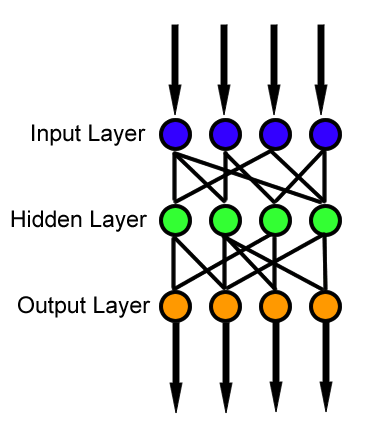
(Source:https://en.wikipedia.org/w/index.php?curid=8201514)


#### Artificial Neuron
An Artifical Neuron is the basic processing unit of a neural network:
- Step 1: calculate the weighted sum of inputs
- Step 2: apply an "activation function" to normalize the sum

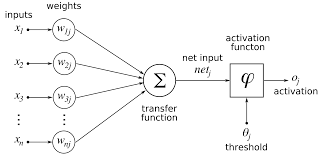
(Source: https://commons.wikimedia.org/w/index.php?curid=224555)

##### References: [Understanding Feedforward Neural Networks](https://www.learnopencv.com/understanding-feedforward-neural-networks/)  [Introduction to FeedForward Neural Networks](https://towardsdatascience.com/feed-forward-neural-networks-c503faa46620)



#### Activation Function

Activation function can be linear or non-linear:
- Normalizing the output
- Defines the decision boundary

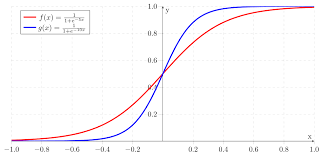
(Source:https://commons.wikimedia.org/wiki/File:Sigmoid-function.svg)


##### References: [Understanding Feedforward Neural Networks](https://www.learnopencv.com/understanding-feedforward-neural-networks/) 

#### Train a DNN Model: Backpropagation

Neural network training typically runs in two phases:
- Forward pass: compute the outputs of each node and the final "loss" of the network
- Backward pass: start at the end of the network and feed the "errors" backward. Apply the chain rule to compute the "gradients" and adjust the weights

##### References: [Breaking down Neural Networks](https://medium.com/spidernitt/breaking-down-neural-networks-an-intuitive-approach-to-backpropagation-3b2ff958794c) 

### Configure an Estimator
The feedforward neural network model is an example of GluonTS "Estimator". In GluonTS, Estimator objects represent a forecasting model and its coefficients, weights, etc.

Each estimator is configured by a number of hyperparameters (e.g., the prediction_length, number of layers for a neural network).

Each estimator is configured by a "Trainer", which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [ ]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[30,30],
    prediction_length=39,
    context_length=52,
    freq='1W',
    trainer=Trainer(ctx="cpu", 
                    epochs=50, 
                    learning_rate=1E-3, 
                    hybridize=False, 
                    num_batches_per_epoch=50
                   )
)

### Train the Model / Getting a Predictor
Invoke the train method of the estimator using the training dataset. The training algorithm returns a fitted model (a "Predictor" in GluonTS) that can be used to generate forecasts.

In [ ]:
predictor = estimator.train(train_data)

#### Saving/Loading an trained model
A trained predictor, can be saved and loaded back:

In [ ]:
# save the trained model in ./model_files/predictor_DNN/
# from pathlib import Path
# predictor.serialize(Path("./model_files/predictor_DNN/"))

In [ ]:
# loads it back
# from gluonts.model.predictor import Predictor
# predictor_deserialized = Predictor.deserialize(Path("./model_files/predictor_DNN/"))

### Generate the Forecasts

We can use the trained model to predict the last window of the `dataset.test` and evaluate the model performance.

GluonTS provides a `make_evaluation_predictions` function to automate this process:
- Remove the final window of `prediction_length` in the `dataset.test`
- Use the remaining dataset to predict (generate sample paths) the "future" window that was removed 
- Outputs a generator over the forecasted sample paths and a generator over the `dataset.test`

In [ ]:
# This function returns generators
forecast_it, ts_it = make_evaluation_predictions(
    test_data, 
    predictor=predictor, 
    num_eval_samples=200)

#  Convert these generators to lists to ease the subsequent computations
forecasts_DNN = list(forecast_it)
tss_DNN = list(ts_it)

Now, let's see what do these lists contain:

In [ ]:
len(tss_DNN)

In [ ]:
tss_DNN[0].head(10)

The `forecasts` list is more complex: Each item is an object that contains all the sample paths (`numpy.ndarray` with dimension `(num_samples, prediction_length)`). It also includes information such as the start date of the forecast, the frequency. 

In [ ]:
len(forecasts_DNN)

In [ ]:
f_entry = forecasts_DNN[0]

In [ ]:
print(f"Frequency of the time series: {f_entry.freq}")
print(f"Start date of the forecast window: {f_entry.start_date}")
print(f"Number of sample paths: {f_entry.num_samples}")
print(f"Dimension of samples: {f_entry.samples.shape}")

#Compute the mean or a given quantile of the forecast
print(f"Mean of the future window:\n {f_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {f_entry.quantile(0.5)}")

Each forecast object has a `plot` method to show the mean, prediction intervals, etc

In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [ ]:
id = 5
plot_prob_forecasts(tss_DNN[id], forecasts_DNN[id])

### Compute Evaluation Metrics
In GluonTS, the Evaluator class compute aggregate performance metrics and evaluation metrics per time series (useful for analyzing performance across heterogeneous time series as we will see later).

In [ ]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.5])
agg_metrics_DNN, item_metrics_DNN = evaluator(iter(tss_DNN), iter(forecasts_DNN), num_series=len(test_data))

#### Individual metrics are aggregated across time-steps of the same time series.

In [ ]:
item_metrics_DNN.head()

#### Aggregate metrics aggregate both across time-steps and across time series.

In [ ]:
print(json.dumps(agg_metrics_DNN, indent=4))

### Baseline Performance: Seasonal Naive Prediction

In [ ]:
from gluonts.model.seasonal_naive import SeasonalNaivePredictor

seasonal_predictor_1W = SeasonalNaivePredictor(freq="W", prediction_length=39)

forecast_it, ts_it = make_evaluation_predictions(test_data,predictor=seasonal_predictor_1W, num_eval_samples=200)
forecasts_naive = list(forecast_it)
tss_naive = list(ts_it)

agg_metrics_naive, item_metrics_naive = evaluator(iter(tss_naive), iter(forecasts_naive), num_series=len(test_data))

In [ ]:
id = 1
plot_prob_forecasts(tss_naive[id], forecasts_naive[id])

In [ ]:
agg_metrics_naive

#### Compare the error measurements of DNN and Seaonal Naive

##### sMAPE: [symmetric mean absolute percentage error](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error)

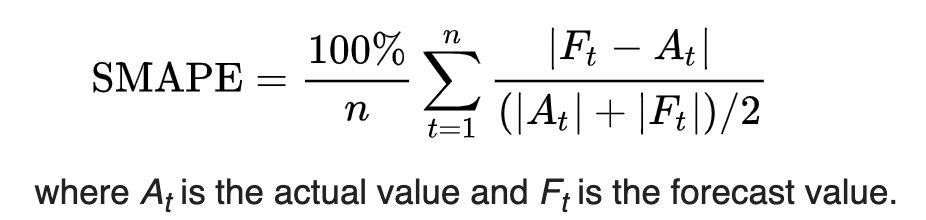

##### RMSE: [root-mean-square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation)

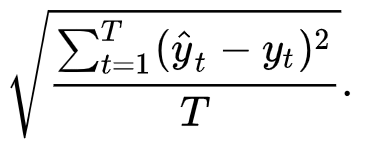

In [ ]:
df_metrics = pd.DataFrame.join(
    pd.DataFrame.from_dict(agg_metrics_DNN, orient='index').rename(columns={0: "DNN"}),
    pd.DataFrame.from_dict(agg_metrics_naive, orient='index').rename(columns={0: "Seasonal Naive"})
)
df_metrics.loc[["sMAPE", "RMSE"]]

### Deep Learning failed to beat baseline on sMAPE!

#### Why? Let's take another look at the individual error metrics

First let's find the time series with extreme sMAPE errors and see what they look like

In [ ]:
x = item_metrics_DNN['sMAPE']
x[x > 1.95].tail(10)

In [ ]:
id = 2757
plot_prob_forecasts(tss_DNN[id], forecasts_DNN[id])

In [ ]:
id = 3012
plot_prob_forecasts(tss_DNN[id], forecasts_DNN[id])

#### Those time series have mostly *zero* sales during the training period

#### Since the training data do not contain too much useful information, let's remove them from the dataset and rerun the DNN model

In [ ]:
# Exclude time series whose mean weekly sales is close to zero during the training period
ts_select = ts.loc[:,ts.iloc[-(39+52):-39,:].mean(axis=0) > 100]

In [ ]:
ts_select.shape
# Load the training/testing datasets
start = pd.Timestamp("02-05-2010", freq='W-FRI')
train_data = [{'target': ts_select[column].head(-39).values, 'start': start} for column in ts_select]
test_data = [{'target': ts_select[column].values, 'start': start} for column in ts_select]


In [ ]:
# Load the training/testing datasets
start = pd.Timestamp("02-05-2010", freq='W-FRI')
train_data = [{'target': ts_select[column].head(-39).values, 'start': start} for column in ts_select]
test_data = [{'target': ts_select[column].values, 'start': start} for column in ts_select]

# Train the model
estimator_DNN2 = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[30,30],
    prediction_length=39,
    context_length=52,
    freq='1W',
    trainer=Trainer(ctx="cpu", 
                    epochs=50, 
                    learning_rate=1E-3, 
                    hybridize=False, 
                    num_batches_per_epoch=50
                   )
)

predictor_DNN2 = estimator_DNN2.train(train_data)

# Generate forecasts
forecast_it, ts_it = make_evaluation_predictions(
    test_data, 
    predictor=predictor_DNN2, 
    num_eval_samples=200)

forecasts_DNN2 = list(forecast_it)
tss_DNN2 = list(ts_it)

# Run evaluations
evaluator = Evaluator(quantiles=[0.5])
agg_metrics_DNN2, item_metrics_DNN2 = evaluator(iter(tss_DNN2), iter(forecasts_DNN2), num_series=len(test_data))

#### Compare the results again: DNN achives lower prediction errors

In [ ]:
# Re-run Seasonal Naive with the filtered datasets
from gluonts.model.seasonal_naive import SeasonalNaivePredictor

seasonal_predictor_1W = SeasonalNaivePredictor(freq="W", prediction_length=39)

forecast_it, ts_it = make_evaluation_predictions(test_data,predictor=seasonal_predictor_1W, num_eval_samples=200)
forecasts_naive2 = list(forecast_it)
tss_naive2 = list(ts_it)

agg_metrics_naive2, item_metrics_naive2 = evaluator(iter(tss_naive2), iter(forecasts_naive2), num_series=len(test_data))

In [ ]:
df_metrics = pd.DataFrame.join(
    pd.DataFrame.from_dict(agg_metrics_DNN2, orient='index').rename(columns={0: "DNN"}),
    pd.DataFrame.from_dict(agg_metrics_naive2, orient='index').rename(columns={0: "Seasonal Naive"})
)
df_metrics.loc[["sMAPE", "RMSE"]]

### Further improve the prediction quality
### Look deeper into the time series characteristics
### The retail dataset includes time series with distinct patterns

#### Clear Seasonal Change

In [ ]:
ts['10_16'].plot()

#### Stational Fluctuation

In [ ]:
ts['10_8'].plot()

#### Seasonal Spikes

In [ ]:
ts['10_18'].plot()

### Consider modeling each sub-group of time series

#### Identify highly correlated store/SKU time series
Calculate the correlation matrix between the time-series and find subset of highly-correlated time series

In [ ]:
corr_mat = ts.corr()

In [ ]:
corr_mat.sort_values(by=['10_16'], ascending=False).head(150)['10_16']

#### Select a subset of time series for forecasting exercise

In [ ]:
ts_select = ts.loc[:,corr_mat.sort_values(by=['10_16'], ascending=False).head(150).index]

In [ ]:
ts_select.shape

#### Re-Run the DNN model

In [ ]:
# Load the training/testing datasets
start = pd.Timestamp("02-05-2010", freq='W-FRI')
train_data = [{'target': ts_select[column].head(-39).values, 'start': start} for column in ts_select]
test_data = [{'target': ts_select[column].values, 'start': start} for column in ts_select]

# Train the model
estimator_DNN3 = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[30,30],
    prediction_length=39,
    context_length=52,
    freq='1W',
    trainer=Trainer(ctx="cpu", 
                    epochs=50, 
                    learning_rate=1E-3, 
                    hybridize=False, 
                    num_batches_per_epoch=50
                   )
)

predictor_DNN3 = estimator_DNN3.train(train_data)

# Generate forecasts
forecast_it, ts_it = make_evaluation_predictions(
    test_data, 
    predictor=predictor_DNN3, 
    num_eval_samples=200)

forecasts_DNN3 = list(forecast_it)
tss_DNN3 = list(ts_it)

# Run evaluations
evaluator = Evaluator(quantiles=[0.5])
agg_metrics_DNN3, item_metrics_DNN3 = evaluator(iter(tss_DNN3), iter(forecasts_DNN3), num_series=len(test_data))

##### New model prediction

In [ ]:
id = 0
plot_prob_forecasts(tss_DNN3[id], forecasts_DNN3[id])

##### Old model prediction

In [ ]:
id = 6
plot_prob_forecasts(tss_DNN[id], forecasts_DNN[id])

#### Compare to the old model prediction results
#### First rerun the old model on the filtered test datasets

In [ ]:
# Generate forecasts
forecast_it, ts_it = make_evaluation_predictions(
    test_data, 
    predictor=predictor_DNN2, # Use the old model for prediction 
    num_eval_samples=200)

forecasts_DNN4 = list(forecast_it)
tss_DNN4 = list(ts_it)

# Run evaluations
evaluator = Evaluator(quantiles=[0.5])
agg_metrics_DNN4, item_metrics_DNN4 = evaluator(iter(tss_DNN4), iter(forecasts_DNN4), num_series=len(test_data))

In [ ]:
df_metrics = pd.DataFrame.join(
    pd.DataFrame.from_dict(agg_metrics_DNN3, orient='index').rename(columns={0: "DNN Trained on Sub-group"}),
    pd.DataFrame.from_dict(agg_metrics_DNN4, orient='index').rename(columns={0: "DNN Trained on All"})
)
df_metrics.loc[["sMAPE", "RMSE"]]

### Other techniques for improving the deep learning forecasting
#### Remove known, steady trend from data and then run DNN modeling
#### Eliminate seasonality ("differencing") and then run DNN Modeling

## Other Deep Learning Models 

### RNN Model

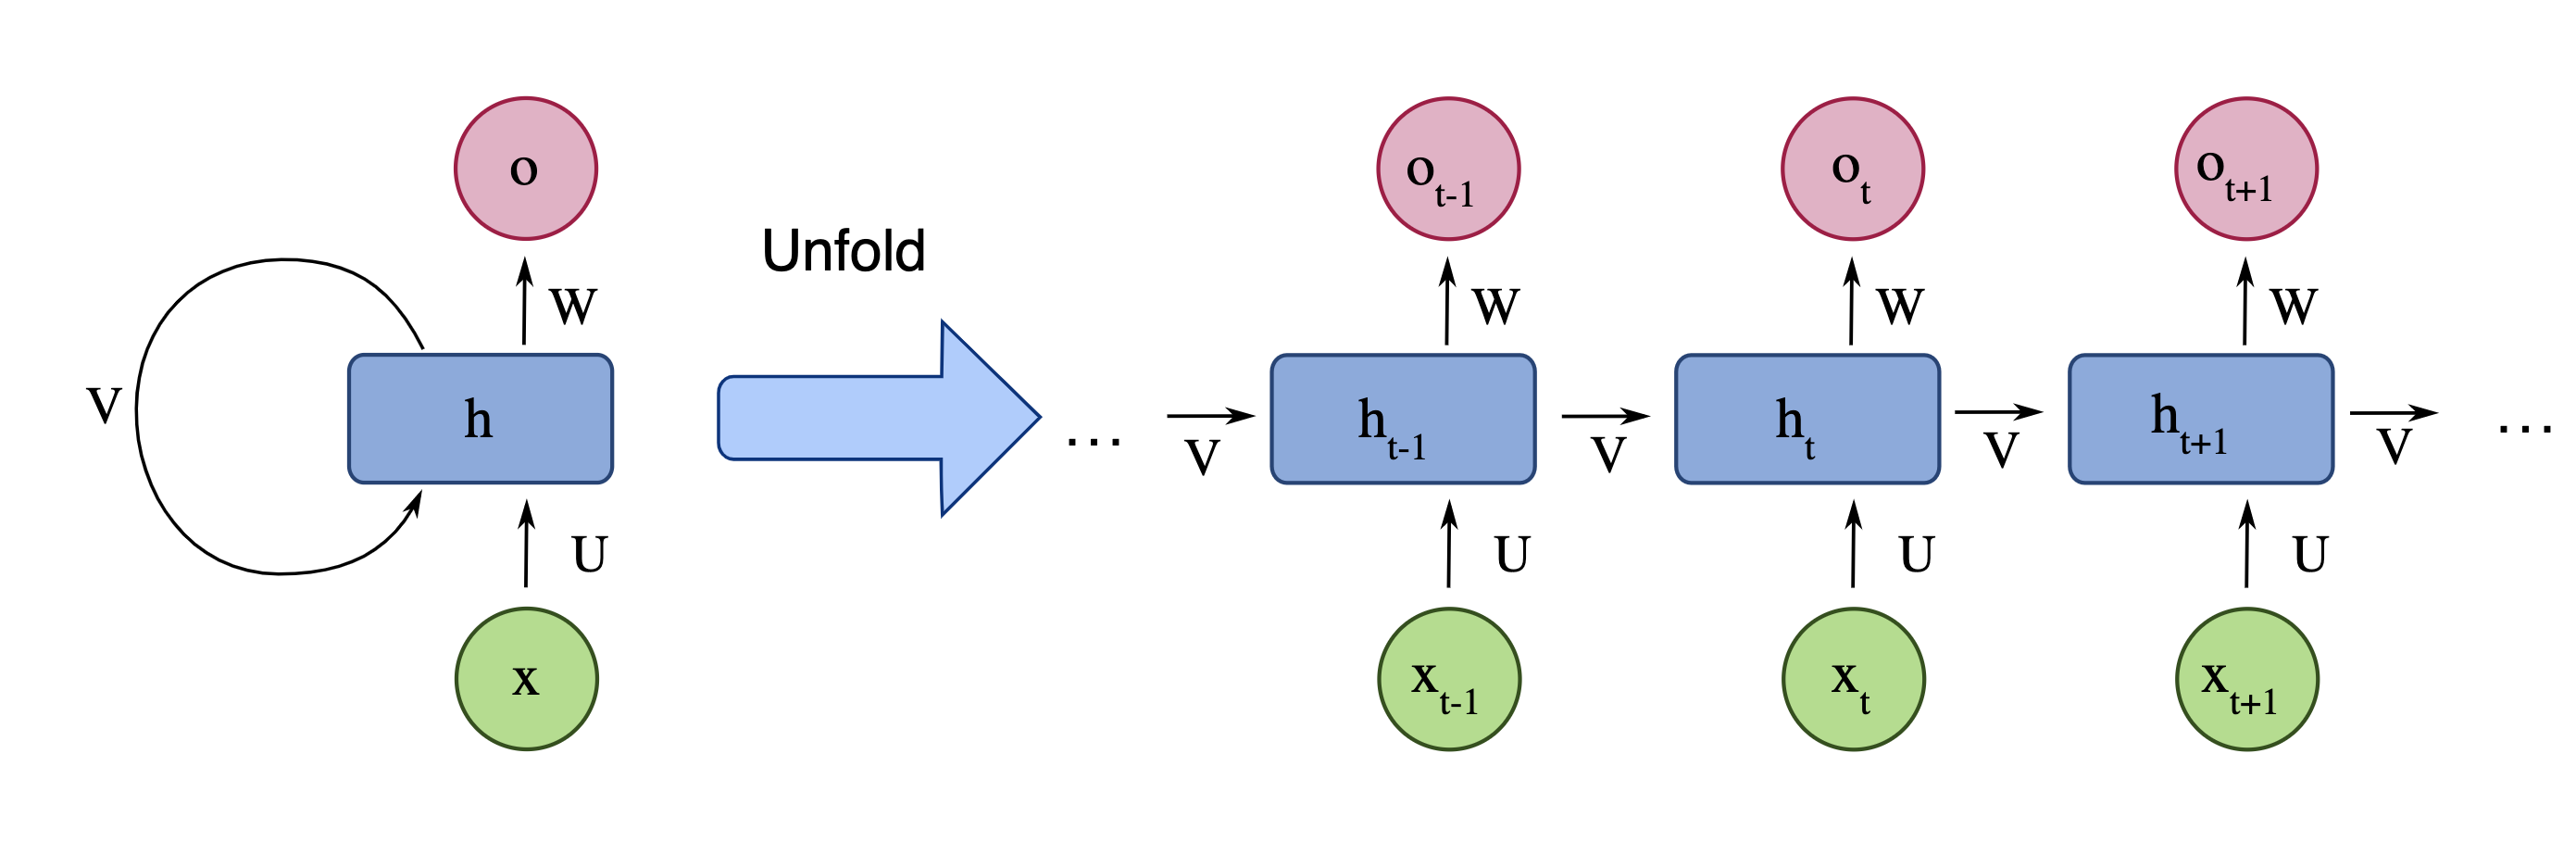
(Source: https://commons.wikimedia.org/w/index.php?curid=60109157)

### GluonTS provides an [RNN implementation](https://gluon-ts.mxnet.io/examples/extended_forecasting_tutorial/extended_tutorial.html#5.4-From-feedforward-to-RNN)

In [ ]:
# estimator = MyProbRNNEstimator(
#         prediction_length=39,
#         context_length=39*2,
#         freq="1W",
#         num_cells=40,
#         num_layers=2,
#         distr_output=GaussianOutput(),
#         trainer=Trainer(ctx="cpu",
#                         epochs=20,
#                         learning_rate=1e-3,
#                         hybridize=False,
#                         num_batches_per_epoch=50
#                        )
#     )

### DeepAR Model
DeepAR model was proposed in the DeepAR paper: Probabilistic Forecasting with Autoregressive Recurrent Networks [Paper link](https://arxiv.org/abs/1704.04110)

### [Using the DeepAR Model in GluonTS](https://aws.amazon.com/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/)

In [ ]:
# estimator = DeepAREstimator(freq="W", 
#                             prediction_length=39, 
#                             trainer=Trainer(epochs=20),
#                             num_layers=2,
#                             num_cells=40)

## Comparison of Various Algorithms

### Reference: [GluonTS Paper](https://arxiv.org/abs/1906.05264)

"Regarding accuracy, there is no overall dominating method. Hence, the experiment
illustrates the need for a flexible modeling toolkit, such as GluonTS, that allows to assemble models quickly for the data set and application at hand."

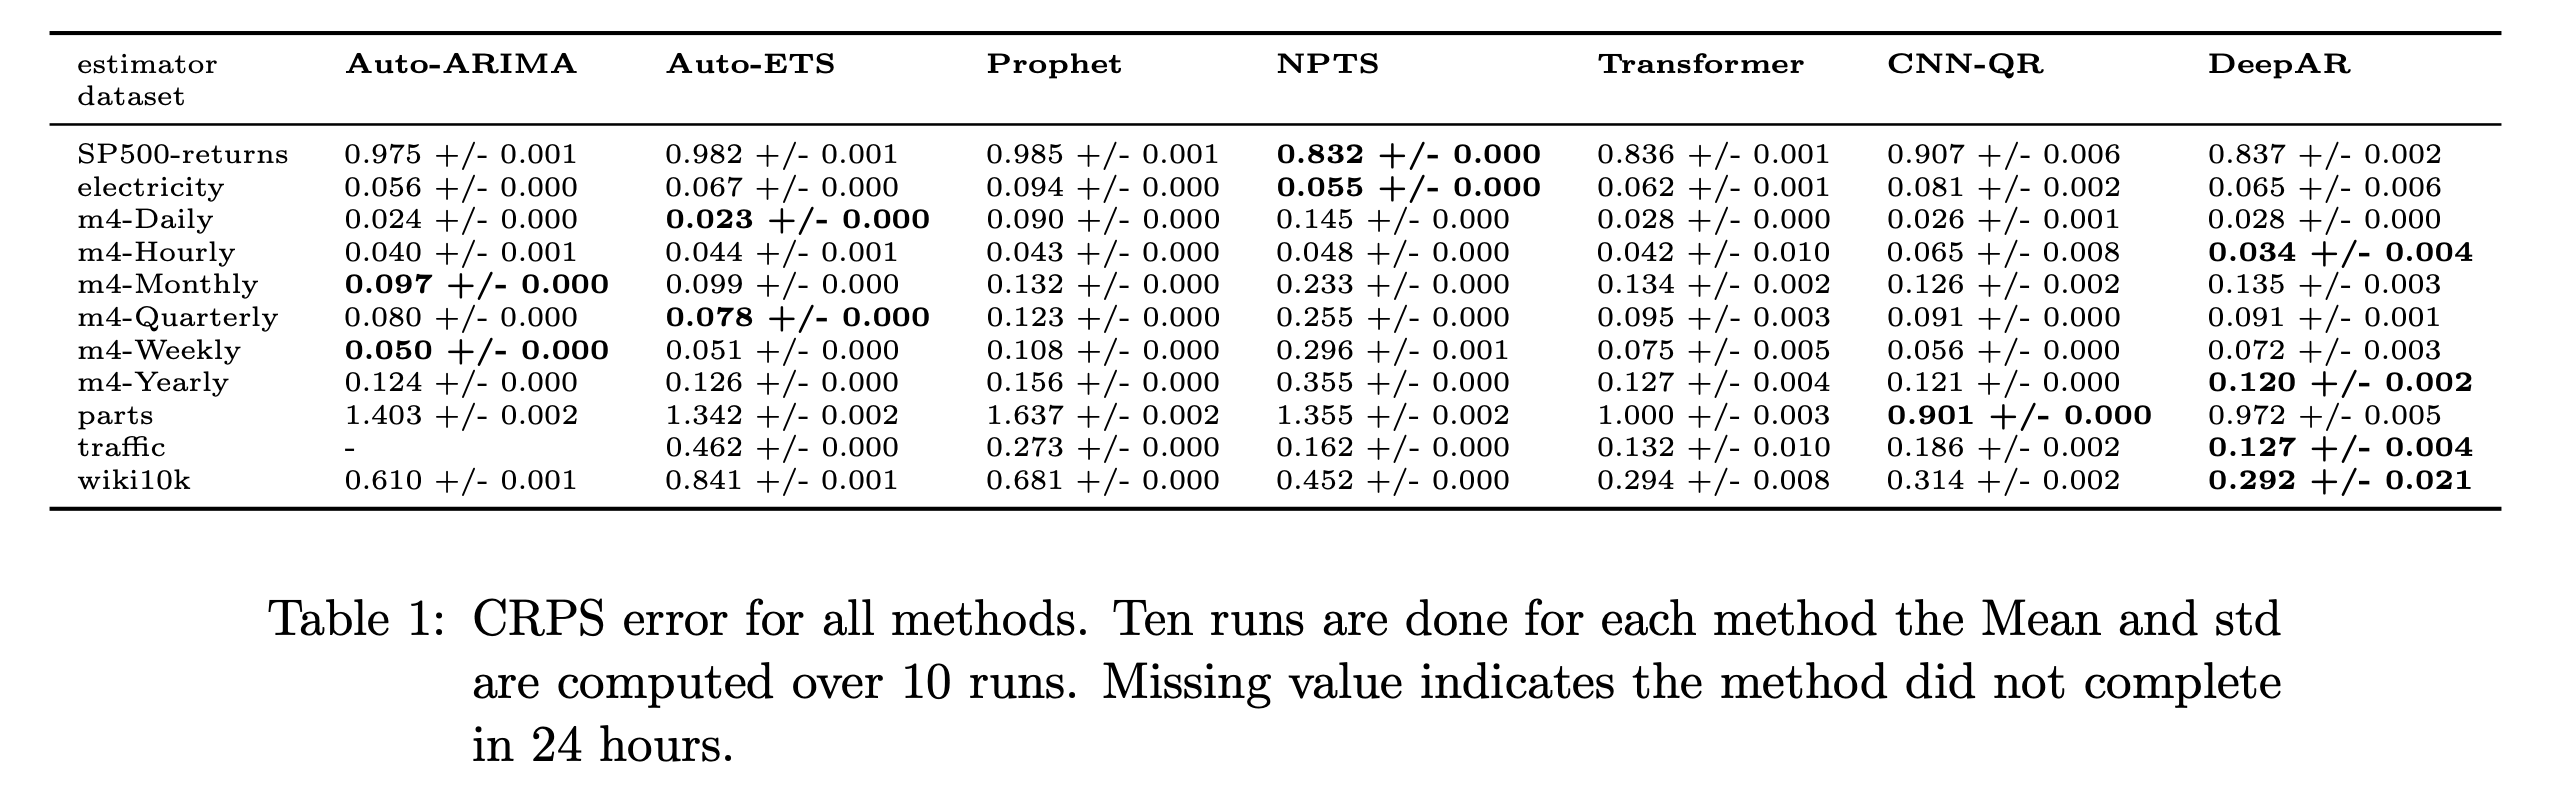